# Image Registration using VoxelMorph

**Introduction**:

Image registration is a critical process in medical image analysis, aiming to align two or more images for comparative and diagnostic purposes. This task becomes increasingly vital in scenarios involving different imaging modalities or temporal intervals.

VoxelMorph, an established approach in this field, utilizes deep learning and the U-Net architecture for streamlined image registration. It accurately aligns images by learning deformations, making it advantageous for complex spatial relationships and detailed feature preservation in medical image analysis.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
import time
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from skimage.transform import resize
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Losses

**Cross Correlation Loss:**
- Calculates the cross-correlation loss between two input tensors.
- Encourages the model to produce similar outputs to the ground truth.

**Smoothing Loss:**
- Measures smoothness by comparing neighboring pixel differences.
- Promotes visually coherent and less noisy predictions.

**Vox Morph Loss:**
- Combines cross-correlation loss and smoothing loss for voxel-based segmentation tasks.
- Encourages accurate segmentation and smooth transitions between neighboring voxels.

**Dice Score:**
- A common metric for segmentation evaluation.
- Compares the overlap and union of predicted and target tensors.
- Higher values indicate better segmentation performance.

In [ ]:
def cross_correlation_loss(I, J, n=9):
    I = I.permute(0, 3, 1, 2).to(device)
    J = J.permute(0, 3, 1, 2).to(device)
    batch_size, channels, xdim, ydim = I.shape
    I2 = torch.mul(I, I).to(device)
    J2 = torch.mul(J, J).to(device)
    IJ = torch.mul(I, J).to(device)
    sum_filter = torch.ones((1, channels, n, n)).to(device)

    I_sum  = torch.conv2d(I,  sum_filter, padding=1, stride=1)
    J_sum  = torch.conv2d(J,  sum_filter, padding=1, stride=1)
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=1)
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=1)
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=1)
    win_size = n ** 2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size
    cc = cross * cross / (I_var * J_var + torch.finfo(torch.float32).eps)
    return torch.mean(cc)

def smoothing_loss(y_pred):
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def dice_score(pred, target):
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    return dice


## Load Data

**Overview of the FIRE Dataset**

The Fundus Image Registration (FIRE) Dataset, detailed at [FIRE Dataset](https://projects.ics.forth.gr/cvrl/fire/), is a specialized collection for image registration research in ophthalmology. It comprises 134 high-resolution fundus photographs, each with a resolution of 2912x2912 pixels. These images are divided into 45 retinal pairs, offering a diverse range of pathologies and anatomical features. This dataset provides a robust platform for evaluating the VoxelMorph framework's accuracy in aligning intricate details in retinal images, crucial for advanced medical image analysis.



In [ ]:
!pip install requests py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.2 MB/s eta 0:00:00


In [ ]:
import requests
import py7zr

# URL of the file you want to download
url = "https://projects.ics.forth.gr/cvrl/fire/FIRE.7z"

# Destination file name
output_file = "FIRE.7z"

# Download the file
response = requests.get(url)
with open(output_file, 'wb') as f:
    f.write(response.content)

# Extract the 7z archive
with py7zr.SevenZipFile(output_file, mode='r') as archive:
    archive.extractall()


In [ ]:
DATA_PATH = './FIRE/Images/'
class my_dataset(Dataset):
    def __init__(self, list_IDs):
        self.list_IDs = list_IDs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        fixed_image = torch.Tensor(resize(io.imread(DATA_PATH + ID + '_1.jpg'), (256, 256, 3)))
        moving_image = torch.Tensor(resize(io.imread(DATA_PATH + ID + '_2.jpg'), (256, 256, 3)))
        return fixed_image, moving_image


filename = list(set([x.split('_')[0] for x in os.listdir(DATA_PATH)]))

partition = {}
partition['train'], partition['validation'] = train_test_split(filename, test_size=0.33, random_state=42)

train_dataset = my_dataset(partition['train'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

val_dataset = my_dataset(partition['validation'])
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

## Model

### Unet

The `UNet` class represents the UNet architecture, a popular neural network model used for semantic segmentation tasks. It consists of contracting and expansive blocks, a bottleneck layer, and decoding layers.

- **Contracting Block** consists of two convolutional layers with batch normalization and ReLU activation. This block reduces the spatial dimensions of the input image.

- **Expansive Block** consists of convolutional layers, batch normalization, ReLU activation, and transposed convolutional layers. This block increases the spatial dimensions of the input image.

- **Final Block** consists of two convolutional layers with batch normalization and ReLU activation. This block is used to obtain the final segmentation output.

- **Crop and Concatenate** method crops the output of the contracting block and concatenates it with the corresponding layer from the expansive block. This operation helps preserve spatial information during the decoding process.


In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels
                  , kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def conv_trans_block(in_channels, out_channels, kernel_size=3,  stride=2, padding=1, output_padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels
                           , kernel_size=kernel_size, stride=stride
                           , padding=padding, output_padding=output_padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def crop_and_concat(upsampled, bypass):
        return torch.cat((upsampled, bypass), 1)

def contracting_block(in_channels, out_channels, kernel_size=3):
      block = torch.nn.Sequential(
          conv_block(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
          conv_block(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
      )
      return block

def expansive_block(in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            conv_block(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            conv_block(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            conv_trans_block(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        return block
def final_block(in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU()
                )
        return block

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = contracting_block(in_channels=in_channels, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 128
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel * 2, padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel*2, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = expansive_block(256, 128, 64)
        self.conv_decode2 = expansive_block(128, 64, 32)

        self.final_layer = final_block(64, 32, out_channels)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)

        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)

        # Decode
        decode_block3 = crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

### Spatial Transformation

The `SpatialTransformation` class is a module used for image registration and spatial transformation. It provides methods for creating a meshgrid, repeating tensors, and interpolating pixel values.

- **Meshgrid**: Generates a 2D grid of coordinates (X and Y values) based on the input height and width.

- **Repeat**: Replicates a tensor multiple times along a specified axis.

- **Interpolate**: Performs bilinear interpolation to estimate pixel values at non-integer coordinates.

- **Forward**: Applies spatial transformation to a moving image using a deformation matrix. Computes new coordinates, performs interpolation, and returns the transformed image.

In [ ]:
class SpatialTransformation(nn.Module):
    def __init__(self):
        super(SpatialTransformation, self).__init__()

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])
        x_t = x_t.cuda()
        y_t = y_t.cuda()

        return x_t, y_t

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)
        x = x.cuda()
        return torch.squeeze(torch.reshape(x, (-1, 1)))

    def interpolate(self, im, x, y):
        im = F.pad(im, (0,0,1,1,1,1,0,0))

        batch_size, height, width, channels = im.shape

        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])
        return output


    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])

        x_new = dx + x_mesh
        y_new = dy + y_mesh


        return self.interpolate(moving_image, x_new, y_new)


### VoxelMorph

In [ ]:
class VoxelMorph(nn.Module):
    def __init__(self, in_channels):
        super(VoxelMorph, self).__init__()
        self.unet = UNet(in_channels*2, 2)
        self.spatial_transform = SpatialTransformation()

    def forward(self, moving_image, fixed_image):
        x = torch.cat([moving_image, fixed_image], dim=3).permute(0,3,1,2)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        #print(deformation_matrix.shape)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image,deformation_matrix




## Train

In [ ]:
num_epochs = 25
num_channels = train_dataset[0][0].shape[2]
voxelmorph = VoxelMorph(num_channels).to(device)
optimizer = optim.Adam(voxelmorph.parameters(), lr=1e-4)

# Initialize lists to store metrics
train_losses = []
train_dice_scores = []
val_losses = []
val_dice_scores = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_dice_score, val_loss, val_dice_score = 0, 0, 0, 0
    num_train_batches, num_val_batches = len(train_loader), len(val_loader)

    # Training Phase
    voxelmorph.train()
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training')
    for batch_fixed, batch_moving in train_loader_tqdm:
        batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)




        optimizer.zero_grad()
        output,deformation_matrix = voxelmorph(batch_moving, batch_fixed)

        #print(batch_moving.shape, batch_fixed.shape, output.shape, torch.cat([batch_moving, batch_fixed], dim=3).permute(0,3,1,2).shape)
        loss = -cross_correlation_loss(output, batch_fixed) - 0.01 * smoothing_loss(deformation_matrix)
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()

        # Update training metrics
        train_loss += loss.item()
        train_dice_score += dice_score(output, batch_fixed)


        # Update progress bar
        train_loader_tqdm.set_postfix(train_loss=train_loss / (train_loader_tqdm.n + 1))
        train_loader_tqdm.update()

    train_loss /= num_train_batches
    train_dice_score /= num_train_batches

    # Validation Phase
    voxelmorph.eval()
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation')
    with torch.no_grad():
        for batch_fixed, batch_moving in val_loader_tqdm:
            batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)


            output,deformation_matrix = voxelmorph(batch_moving, batch_fixed)
            loss = -cross_correlation_loss(output, batch_fixed) - 0.01 * smoothing_loss(deformation_matrix)

            # Update validation metrics
            val_loss += loss.item()
            val_dice_score += dice_score(output, batch_fixed)

            # Update progress bar
            val_loader_tqdm.set_postfix(val_loss=val_loss / (val_loader_tqdm.n + 1))
            val_loader_tqdm.update()
            #plot_samples(batch_fixed, batch_moving, output, k=1)

    val_loss /= num_val_batches
    val_dice_score /= num_val_batches

    # Append metrics to lists
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice_score)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice_score)

    # Print epoch summary
    epoch_duration = (time.time() - epoch_start_time) / 60
    print(f"Epoch {epoch + 1}/{num_epochs} - Duration: {epoch_duration:.2f} mins - Train Loss: {train_loss:.3f}, Train DICE: {train_dice_score:.3f}, Val Loss: {val_loss:.3f}, Val DICE: {val_dice_score:.3f}")





Epoch 1/25 - Training:   0%|          | 0/89 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/25 - Validation: 100%|██████████| 45/45 [02:11<00:00,  2.91s/it, val_loss=-0.667]


Epoch 1/25 - Duration: 6.75 mins - Train Loss: -0.735, Train DICE: 0.471, Val Loss: -0.800, Val DICE: 0.462


Epoch 2/25 - Validation: 100%|██████████| 45/45 [02:07<00:00,  2.84s/it, val_loss=-0.662]


Epoch 2/25 - Duration: 6.37 mins - Train Loss: -0.887, Train DICE: 0.471, Val Loss: -0.794, Val DICE: 0.461


Epoch 3/25 - Validation: 100%|██████████| 45/45 [02:08<00:00,  2.86s/it, val_loss=-0.634]


Epoch 3/25 - Duration: 6.34 mins - Train Loss: -0.833, Train DICE: 0.471, Val Loss: -0.775, Val DICE: 0.461


Epoch 4/25 - Validation: 100%|██████████| 45/45 [02:08<00:00,  2.86s/it, val_loss=-0.724]


Epoch 4/25 - Duration: 6.37 mins - Train Loss: -0.728, Train DICE: 0.471, Val Loss: -0.868, Val DICE: 0.461


Epoch 5/25 - Validation: 100%|██████████| 45/45 [02:10<00:00,  2.90s/it, val_loss=-0.696]


Epoch 5/25 - Duration: 6.43 mins - Train Loss: -0.749, Train DICE: 0.470, Val Loss: -0.835, Val DICE: 0.461


Epoch 6/25 - Validation: 100%|██████████| 45/45 [02:10<00:00,  2.90s/it, val_loss=-0.64]


Epoch 6/25 - Duration: 6.45 mins - Train Loss: -1.273, Train DICE: 0.471, Val Loss: -0.767, Val DICE: 0.461


Epoch 7/25 - Validation: 100%|██████████| 45/45 [02:10<00:00,  2.90s/it, val_loss=-1.86]


Epoch 7/25 - Duration: 6.47 mins - Train Loss: -0.773, Train DICE: 0.471, Val Loss: -2.232, Val DICE: 0.461


Epoch 8/25 - Validation: 100%|██████████| 45/45 [02:09<00:00,  2.89s/it, val_loss=-0.683]


Epoch 8/25 - Duration: 6.39 mins - Train Loss: -0.816, Train DICE: 0.471, Val Loss: -0.820, Val DICE: 0.461


Epoch 9/25 - Validation: 100%|██████████| 45/45 [02:09<00:00,  2.88s/it, val_loss=-0.674]


Epoch 9/25 - Duration: 6.42 mins - Train Loss: -0.812, Train DICE: 0.471, Val Loss: -0.808, Val DICE: 0.461


Epoch 10/25 - Validation: 100%|██████████| 45/45 [02:09<00:00,  2.88s/it, val_loss=-0.658]


Epoch 10/25 - Duration: 6.40 mins - Train Loss: -0.765, Train DICE: 0.471, Val Loss: -0.790, Val DICE: 0.461


Epoch 11/25 - Validation: 100%|██████████| 45/45 [02:10<00:00,  2.89s/it, val_loss=-0.672]


Epoch 11/25 - Duration: 6.38 mins - Train Loss: -0.848, Train DICE: 0.471, Val Loss: -0.822, Val DICE: 0.461


Epoch 12/25 - Validation: 100%|██████████| 45/45 [02:09<00:00,  2.88s/it, val_loss=-0.651]


Epoch 12/25 - Duration: 6.41 mins - Train Loss: -0.773, Train DICE: 0.471, Val Loss: -0.781, Val DICE: 0.461


Epoch 13/25 - Validation: 100%|██████████| 45/45 [02:08<00:00,  2.87s/it, val_loss=-0.614]


Epoch 13/25 - Duration: 6.41 mins - Train Loss: -0.845, Train DICE: 0.471, Val Loss: -0.737, Val DICE: 0.461


Epoch 14/25 - Validation: 100%|██████████| 45/45 [02:08<00:00,  2.87s/it, val_loss=-0.645]


Epoch 14/25 - Duration: 6.40 mins - Train Loss: -0.816, Train DICE: 0.470, Val Loss: -0.774, Val DICE: 0.461


Epoch 15/25 - Validation: 100%|██████████| 45/45 [02:07<00:00,  2.84s/it, val_loss=-0.65]


Epoch 15/25 - Duration: 6.39 mins - Train Loss: -0.685, Train DICE: 0.470, Val Loss: -0.780, Val DICE: 0.461


Epoch 16/25 - Validation: 100%|██████████| 45/45 [02:06<00:00,  2.82s/it, val_loss=-0.676]


Epoch 16/25 - Duration: 6.28 mins - Train Loss: -0.757, Train DICE: 0.470, Val Loss: -0.811, Val DICE: 0.461


Epoch 17/25 - Validation: 100%|██████████| 45/45 [02:06<00:00,  2.80s/it, val_loss=-0.594]


Epoch 17/25 - Duration: 6.23 mins - Train Loss: -0.730, Train DICE: 0.470, Val Loss: -0.726, Val DICE: 0.461


Epoch 18/25 - Validation: 100%|██████████| 45/45 [02:06<00:00,  2.81s/it, val_loss=-0.655]


Epoch 18/25 - Duration: 6.26 mins - Train Loss: -0.790, Train DICE: 0.470, Val Loss: -0.801, Val DICE: 0.461


Epoch 19/25 - Validation: 100%|██████████| 45/45 [02:06<00:00,  2.80s/it, val_loss=-0.619]


Epoch 19/25 - Duration: 6.24 mins - Train Loss: -0.696, Train DICE: 0.470, Val Loss: -0.743, Val DICE: 0.461


Epoch 20/25 - Validation: 100%|██████████| 45/45 [02:05<00:00,  2.79s/it, val_loss=-0.651]


Epoch 20/25 - Duration: 6.21 mins - Train Loss: -0.745, Train DICE: 0.470, Val Loss: -0.781, Val DICE: 0.461


Epoch 21/25 - Validation: 100%|██████████| 45/45 [02:05<00:00,  2.78s/it, val_loss=-0.377]


Epoch 21/25 - Duration: 6.21 mins - Train Loss: -1.631, Train DICE: 0.470, Val Loss: -0.452, Val DICE: 0.457


Epoch 22/25 - Validation: 100%|██████████| 45/45 [02:04<00:00,  2.77s/it, val_loss=-0.66]


Epoch 22/25 - Duration: 6.19 mins - Train Loss: -0.773, Train DICE: 0.472, Val Loss: -0.806, Val DICE: 0.462


Epoch 23/25 - Validation: 100%|██████████| 45/45 [02:06<00:00,  2.80s/it, val_loss=-0.658]


Epoch 23/25 - Duration: 6.22 mins - Train Loss: -0.770, Train DICE: 0.472, Val Loss: -0.789, Val DICE: 0.462


Epoch 24/25 - Validation: 100%|██████████| 45/45 [02:06<00:00,  2.81s/it, val_loss=-0.678]


Epoch 24/25 - Duration: 6.25 mins - Train Loss: -0.780, Train DICE: 0.472, Val Loss: -0.813, Val DICE: 0.462


Epoch 25/25 - Validation: 100%|██████████| 45/45 [02:05<00:00,  2.78s/it, val_loss=-0.673]

Epoch 25/25 - Duration: 6.25 mins - Train Loss: -0.809, Train DICE: 0.472, Val Loss: -0.808, Val DICE: 0.462


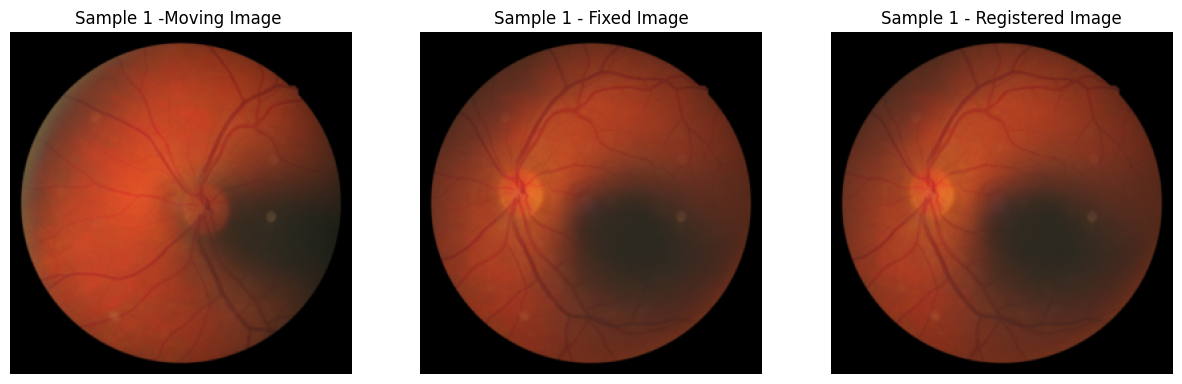

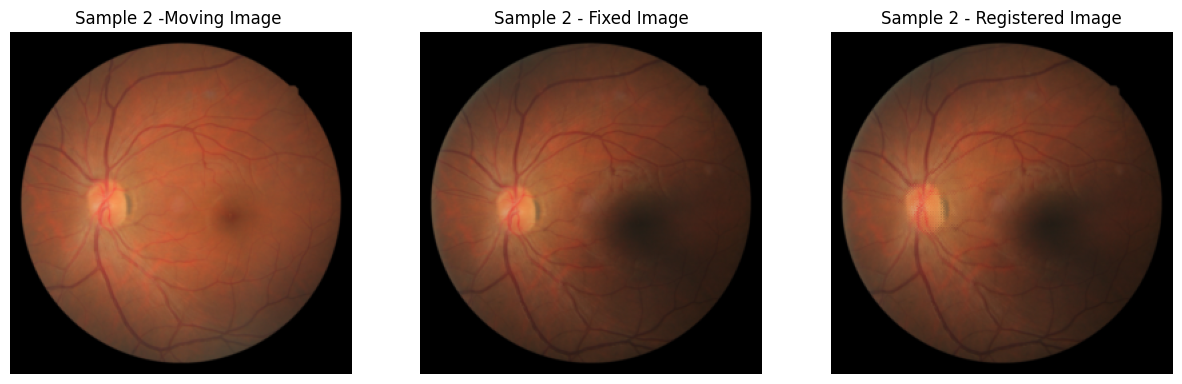

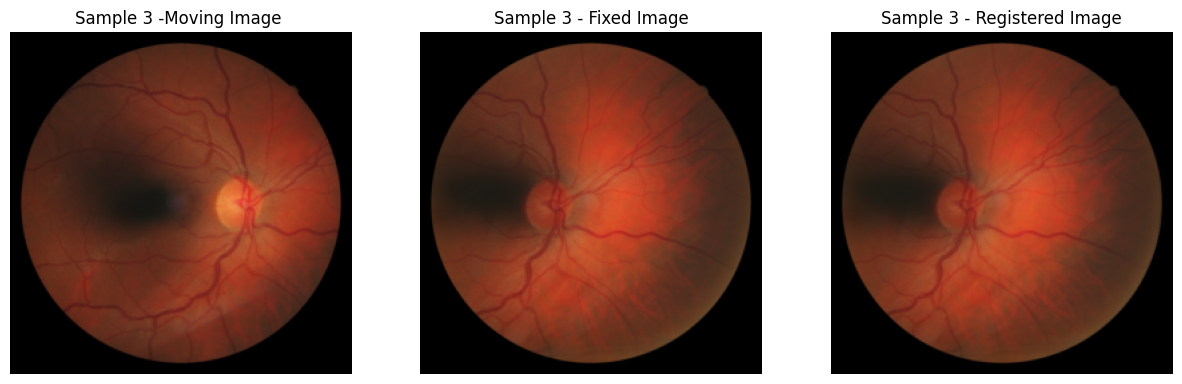

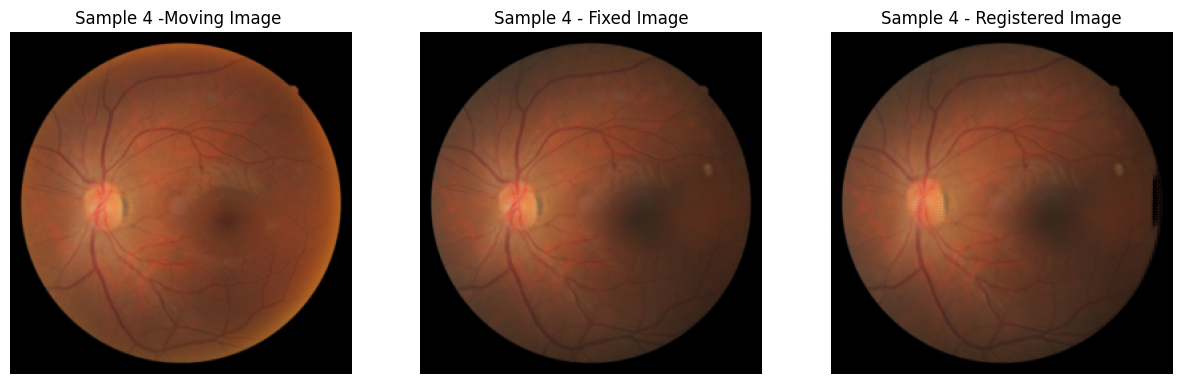

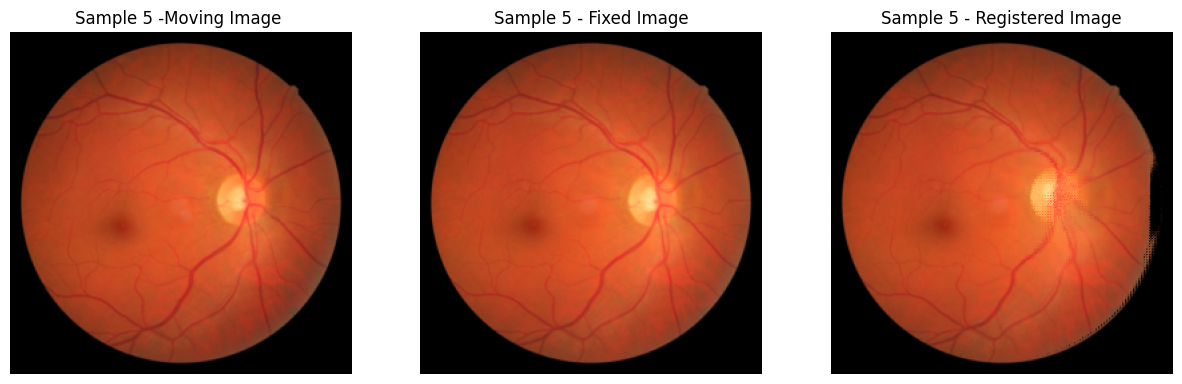

In [ ]:
def plot_samples(batch_fixed, batch_moving, registered_image, k, j):
    """
    Plot k samples from batch_fixed, batch_moving, and registered_image.
    """
    fig, axs = plt.subplots(k, 3, figsize=(15, 5 * k))  # Adjust the figure size as needed

    # Ensure that batch_fixed, batch_moving, and registered_image are lists of tensors
    if not isinstance(batch_fixed, list):
        batch_fixed = [batch_fixed]
    if not isinstance(batch_moving, list):
        batch_moving = [batch_moving]
    if not isinstance(registered_image, list):
        registered_image = [registered_image]

    for i in range(k):
        # Plot fixed image
        if i < len(batch_fixed):
            axs[0].imshow(batch_fixed[i].cpu().squeeze(), cmap='gray')
            axs[0].set_title(f'Sample {j} -Moving Image ')
            axs[0].axis('off')

        # Plot moving image
        if i < len(batch_moving):
            axs[1].imshow(batch_moving[i].cpu().squeeze(), cmap='gray')
            axs[1].set_title(f'Sample {j} - Fixed Image')
            axs[1].axis('off')

        # Plot registered image
        if i < len(registered_image):
            axs[2].imshow(registered_image[i].cpu().squeeze(), cmap='gray')
            axs[2].set_title(f'Sample {j} - Registered Image')
            axs[2].axis('off')

    plt.show()


# # Example usage (within your training or validation loop, or after a forward pass)
# j = 0
# voxelmorph.eval()
# with torch.no_grad():
#   for batch_fixed, batch_moving in val_loader:
#     j += 1
#     batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)
#     registered_image = voxelmorph(batch_moving, batch_fixed)
#     plot_samples(batch_fixed, batch_moving, registered_image, 1, j)
#     if j >= 5:
#       break

# Example usage (within your training or validation loop, or after a forward pass)
j = 0
voxelmorph.eval()
with torch.no_grad():
  for batch_fixed, batch_moving in val_loader:
    j += 1
    batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)
    output, _ = voxelmorph(batch_moving, batch_fixed)  # Ensure to unpack the output tuple
    registered_image = output  # Assuming the registered image is the first element of the output tuple
    plot_samples(batch_fixed, batch_moving, registered_image, 1, j)
    if j >= 5:
      break



In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))

    # Plotting Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()



    plt.tight_layout()
    plt.show()


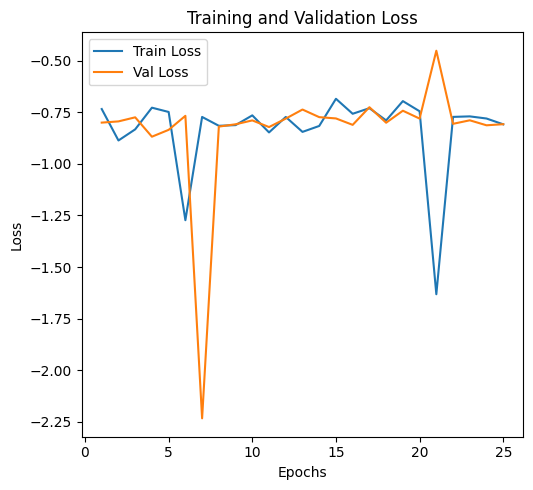

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))

    # Plotting Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()



    plt.tight_layout()
    plt.show()




plot_learning_curves(train_losses, val_losses)

In [ ]:
pip install simpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.3 MB/s eta 0:00:00


Checkerboard

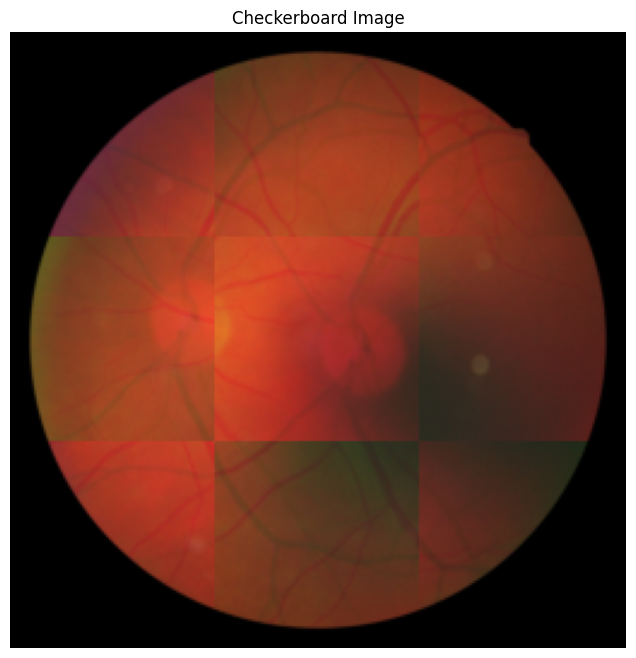

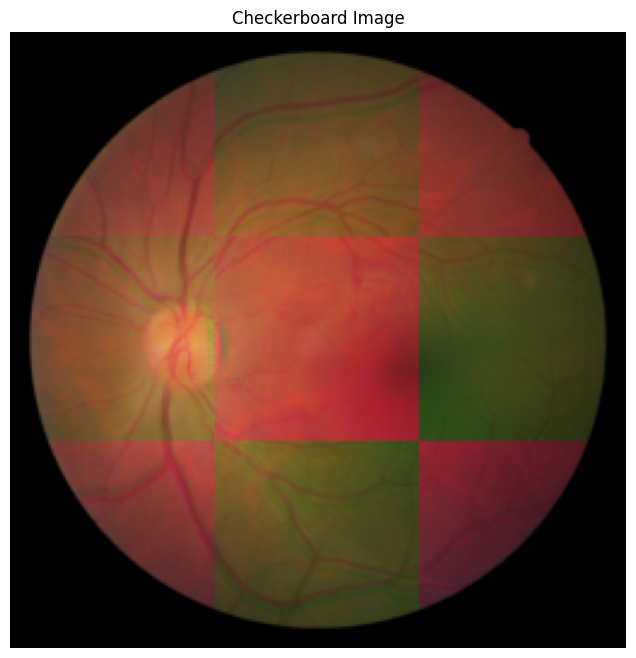

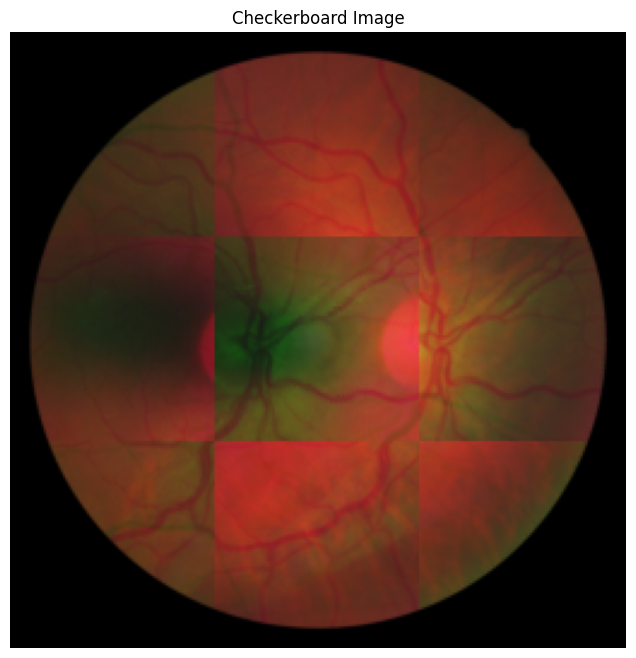

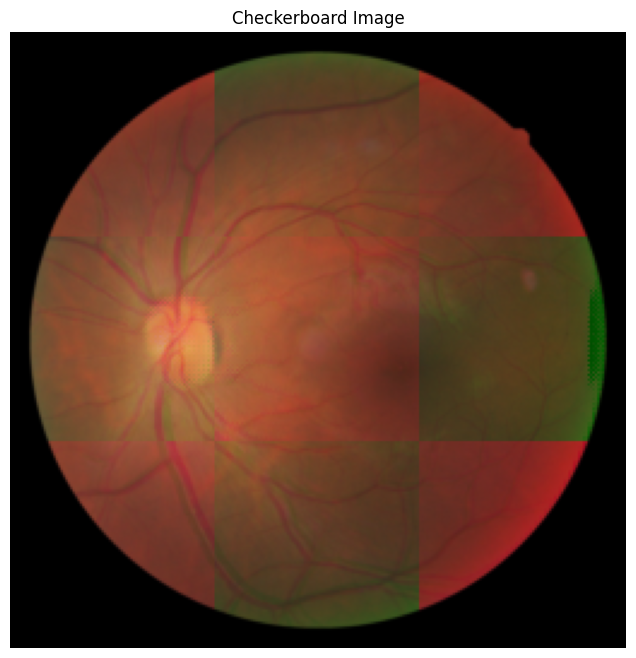

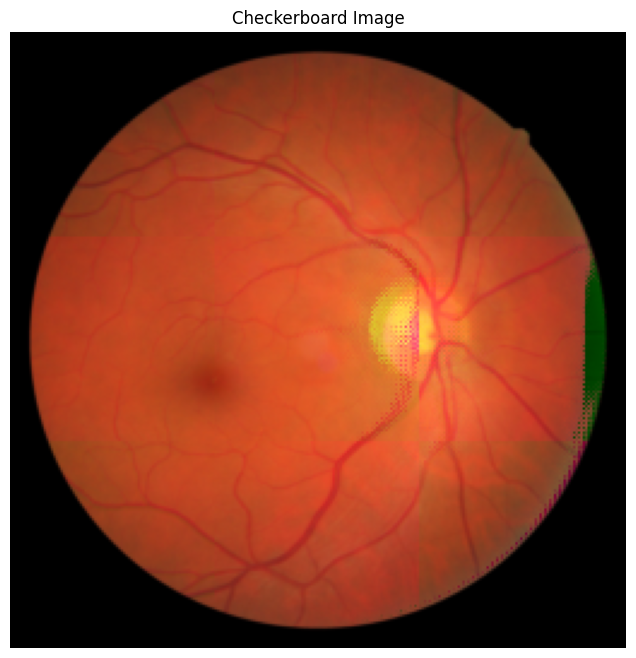

In [ ]:
import torch
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

def create_checkerboard_image(image1, image2, checkerboard_pattern=[3, 3]):
    # Check if checkerboard_pattern is a list or tuple with two elements
    if isinstance(checkerboard_pattern, (list, tuple)) and len(checkerboard_pattern) == 2:
        checkerboard_pattern_vector = sitk.VectorUInt32(checkerboard_pattern[0], checkerboard_pattern[1])
    else:
        # Use default pattern if checkerboard_pattern is invalid
        checkerboard_pattern_vector = sitk.VectorUInt32(3, 3)

    # Create CheckerBoardImageFilter instance
    checkerboard_filter = sitk.CheckerBoardImageFilter()

    # Set checkerboard pattern
    checkerboard_filter.SetCheckerPattern(checkerboard_pattern_vector)

    # Convert PyTorch tensors to numpy arrays and then to SimpleITK images
    image1_sitk = sitk.GetImageFromArray(image1.cpu().numpy().squeeze())
    image2_sitk = sitk.GetImageFromArray(image2.cpu().numpy().squeeze())

    # Execute the filter to get the combined checkerboard image
    checkerboard_image = checkerboard_filter.Execute(image1_sitk, image2_sitk)

    # Convert SimpleITK image to NumPy array for plotting
    checkerboard_np = sitk.GetArrayFromImage(checkerboard_image)

    # Plot the checkerboard image
    plt.figure(figsize=(8, 8))
    plt.imshow(checkerboard_np, cmap='gray')
    plt.title('Checkerboard Image')
    plt.axis('off')
    plt.show()

# Assuming 'voxelmorph' is defined and 'val_loader' is your data loader
j = 0
voxelmorph.eval()
with torch.no_grad():
    for batch_fixed, batch_moving in val_loader:
        j += 1
        batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)
        output, _ = voxelmorph(batch_moving, batch_fixed)  # Ensure to unpack the output tuple

        # Assuming output, batch_fixed, and batch_moving are tensors
        create_checkerboard_image(batch_fixed,  output)

        if j >= 5:
            break


In [ ]:
import numpy as np

def plot_samples_with_overlay(batch_fixed, batch_moving, registered_image, k, j):
    """
    Plot k samples from batch_fixed, batch_moving, and registered_image with overlays.
    Also, plot registration error maps.
    """
    fig, axs = plt.subplots(k, 4, figsize=(20, 5 * k))  # Adjust the figure size as needed

    if k == 1:
        axs = np.expand_dims(axs, axis=0)  # Ensure axs is 2-dimensional for single-sample case

    for i in range(k):
        # Plot moving image with overlay
        if i < len(batch_moving):
            moving_img = batch_moving[i].cpu().squeeze().numpy()
            overlay_img = np.where(moving_img > 0, 0.5, 0)  # Create an overlay mask (e.g., 50% transparent where moving image has values)
            axs[i, 0].imshow(moving_img, cmap='gray')
            axs[i, 0].imshow(overlay_img, cmap='spring', alpha=0.5)
            axs[i, 0].set_title(f'Sample {j} - Moving Image with Overlay')
            axs[i, 0].axis('off')

        # Plot registered image
        if i < len(registered_image):
            registered_img = registered_image[i].cpu().squeeze().numpy()
            axs[i, 1].imshow(registered_img, cmap='gray')
            axs[i, 1].set_title(f'Sample {j} - Registered Image')
            axs[i, 1].axis('off')

        # Plot fixed image with overlay
        if i < len(batch_fixed):
            fixed_img = batch_fixed[i].cpu().squeeze().numpy()
            overlay_img = np.where(fixed_img > 0, 0.5, 0)  # Create an overlay mask (e.g., 50% transparent where fixed image has values)
            axs[i, 2].imshow(fixed_img, cmap='gray')
            axs[i, 2].imshow(overlay_img, cmap='summer', alpha=0.5)
            axs[i, 2].set_title(f'Sample {j} - Fixed Image with Overlay')
            axs[i, 2].axis('off')

        # Compute and plot registration error map
        if i < len(batch_fixed) and i < len(registered_image):
            error_map = np.abs(moving_img - registered_img)
            axs[i, 3].imshow(error_map, cmap='viridis')
            axs[i, 3].set_title(f'Sample {j} - Registration Error Map')
            axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


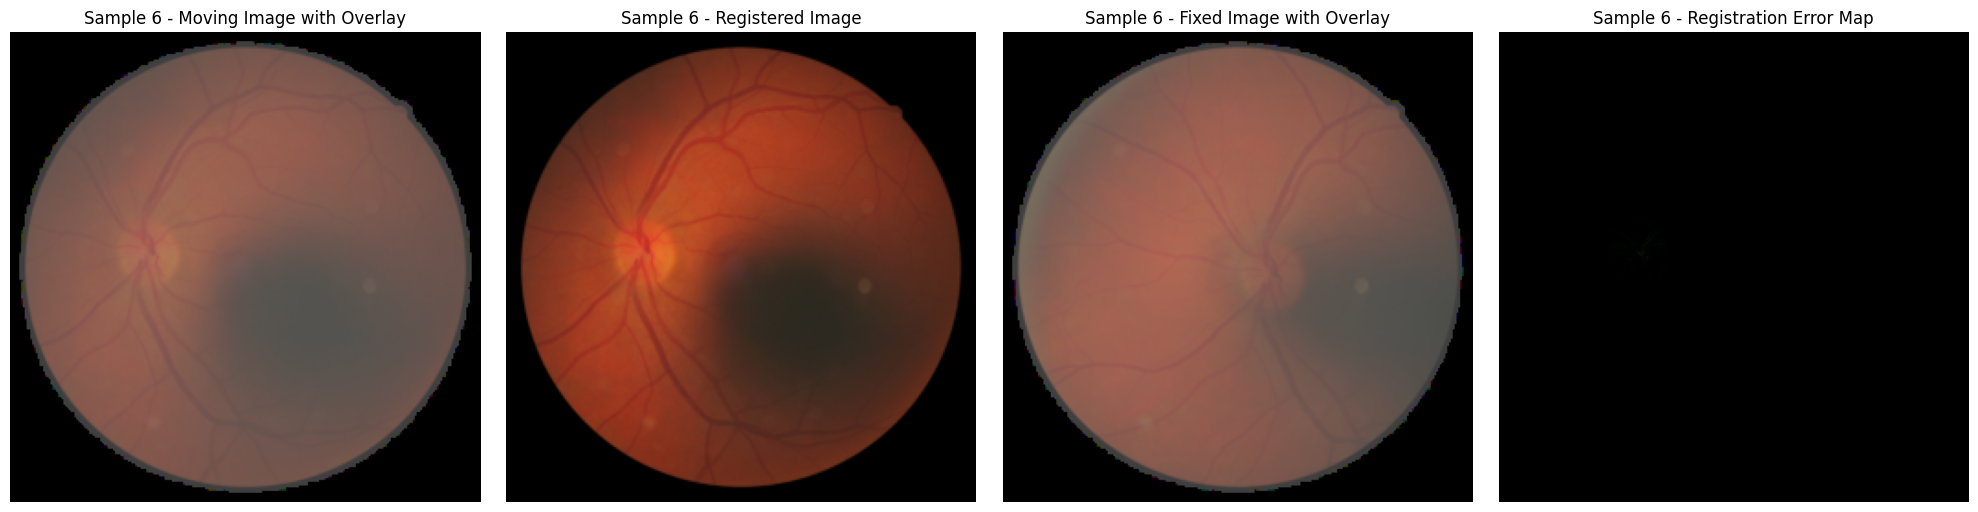

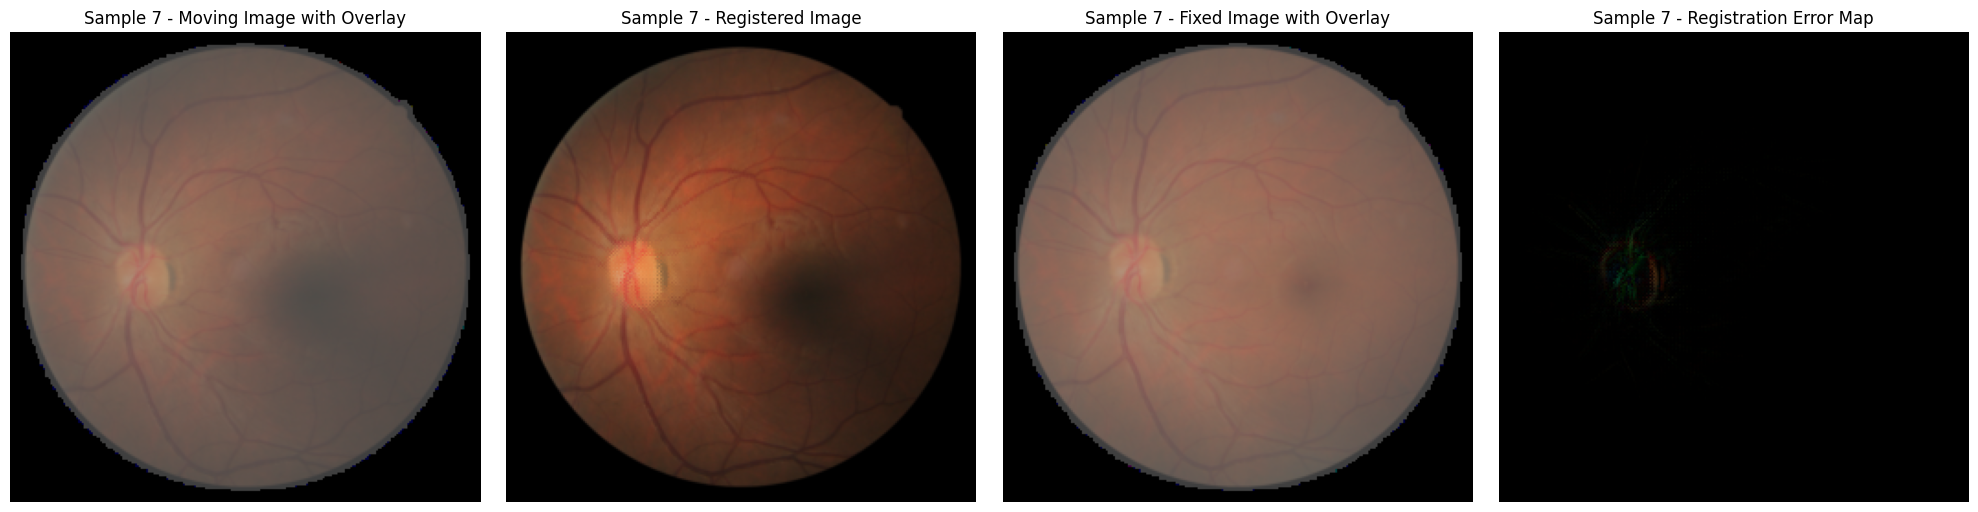

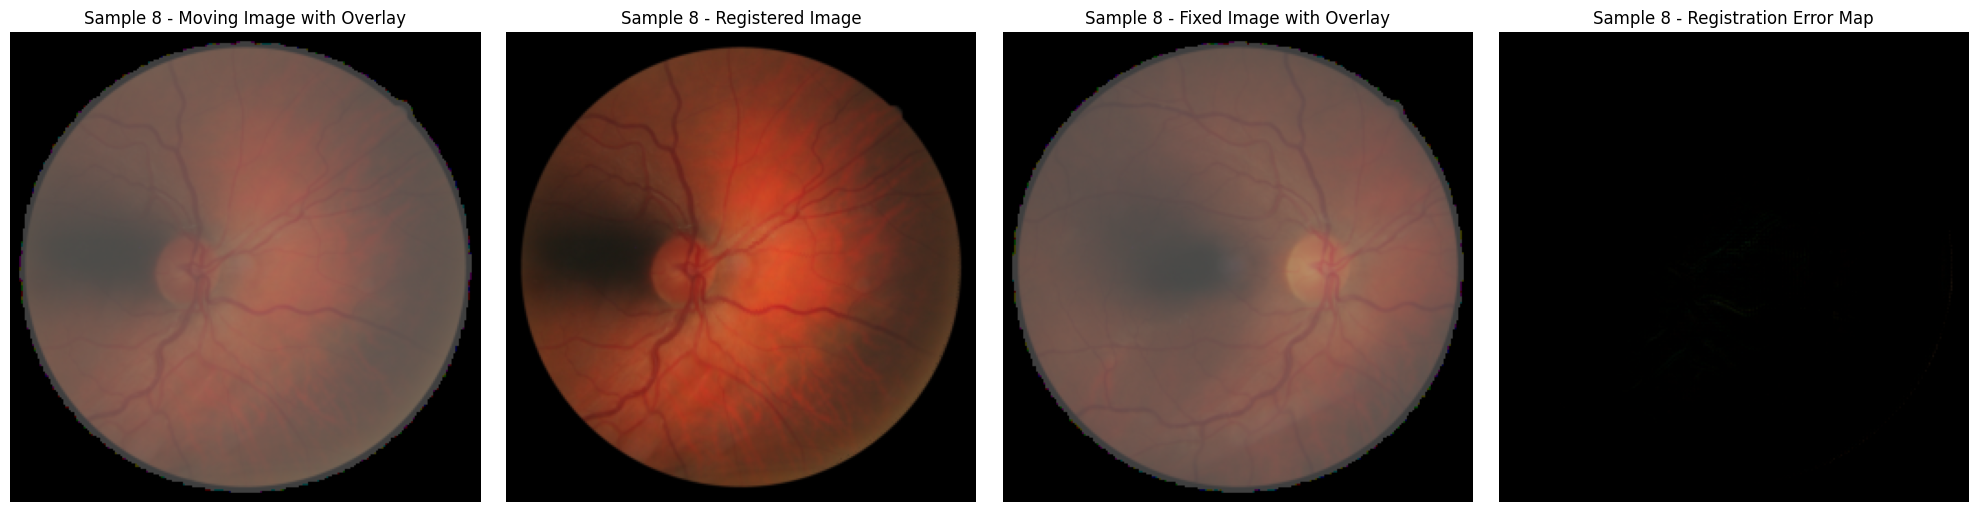

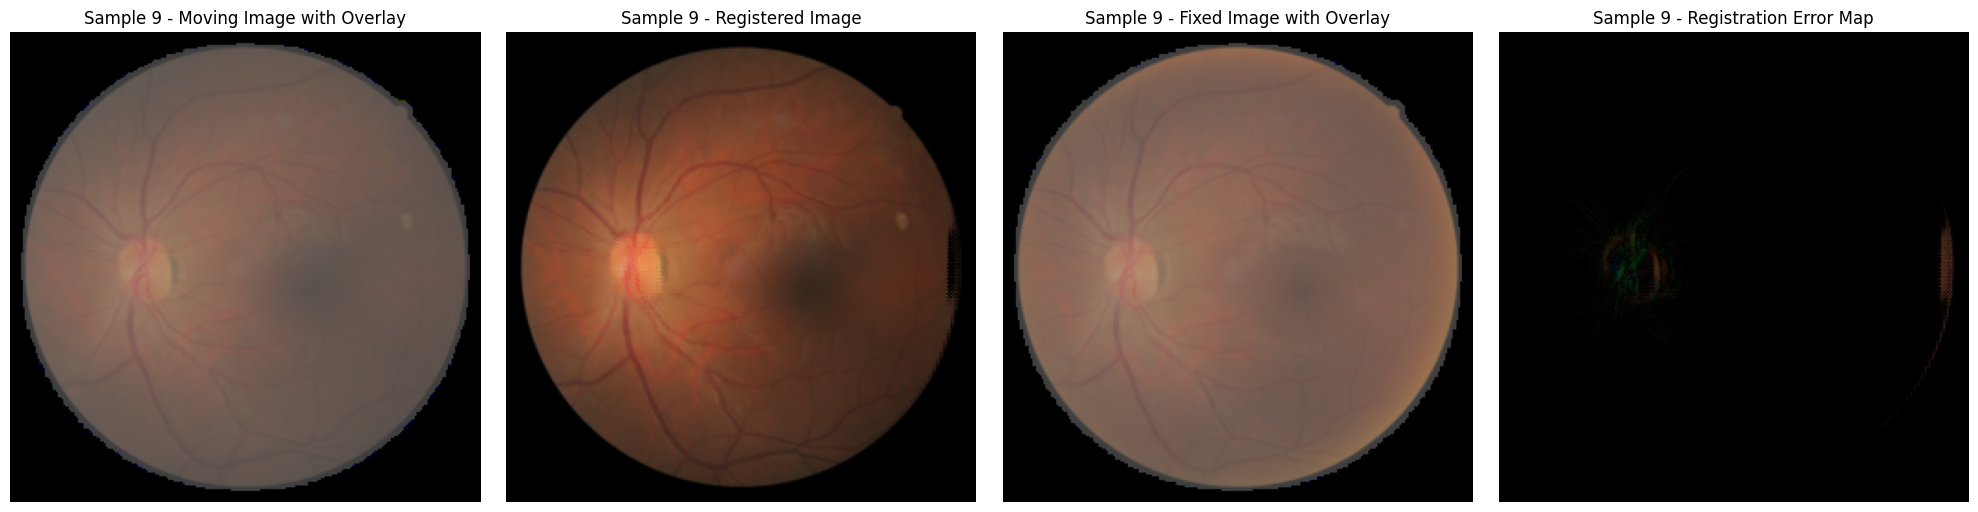

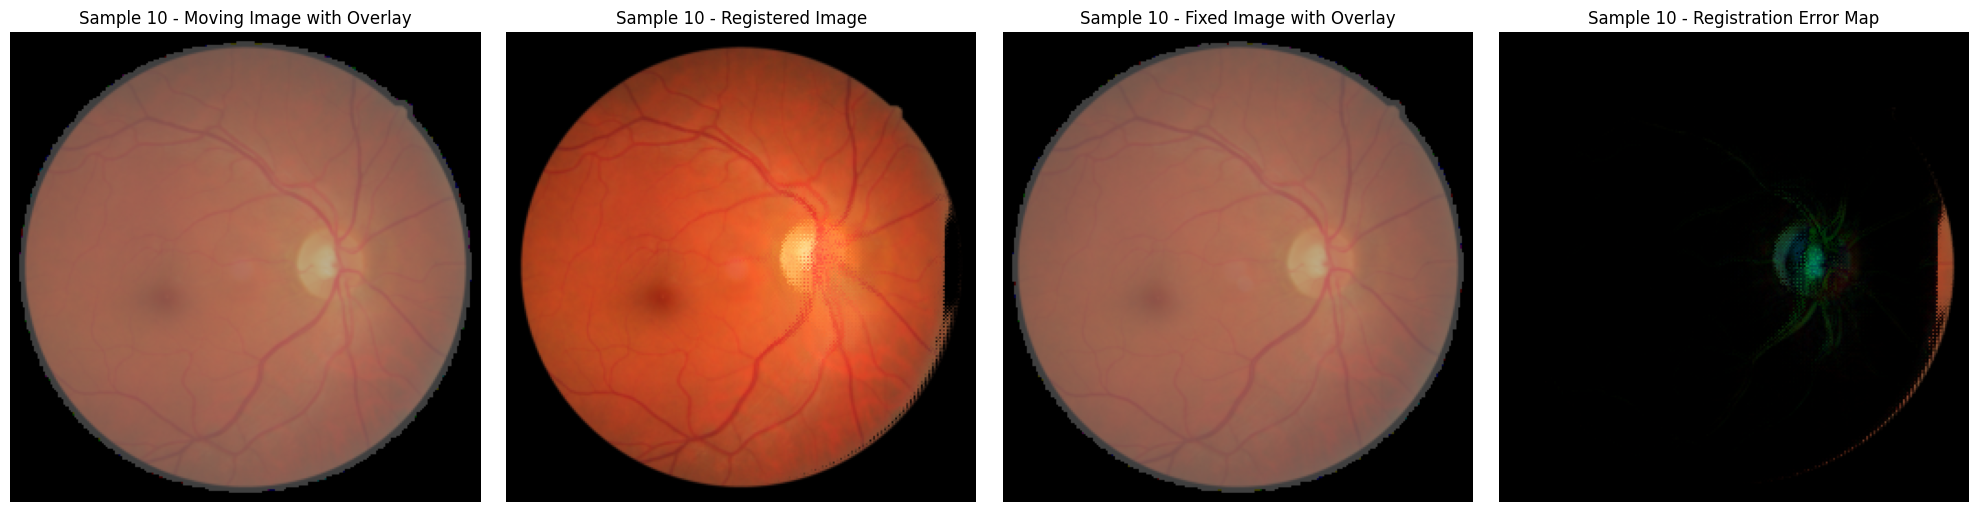

In [ ]:
# Inside your training/validation loop

# After training loop ends, plot learning curves


# Example usage of plot_samples_with_overlay during validation
j = 5
voxelmorph.eval()
with torch.no_grad():
    for batch_fixed, batch_moving in val_loader:
        j += 1
        batch_fixed, batch_moving = batch_fixed.to(device), batch_moving.to(device)
        registered_image = voxelmorph(batch_moving, batch_fixed)
        plot_samples_with_overlay(batch_fixed, batch_moving, registered_image, 1, j)
        if j >= 10:
            break
